In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.regularizers import L1L2
from keras import optimizers
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 6.0]

In [63]:
## Data
abw = pd.read_csv(
    "~/user/Downloads/20220502_142656.csv", parse_dates=True
).rename(columns={"Abwasser 7T": "WW_7days", "Abwasser Täglich": "daily", "__timestamp": "Date"}).set_index("Date")
abw["WW_14days"] = abw["daily"].rolling(14, min_periods=1).sum()
abw["WW_28days"] = abw["daily"].rolling(28, min_periods=1).sum()
abw.index = pd.to_datetime(abw.index).strftime("%Y-%m-%d")
rki = pd.read_csv("Dresden_RKI_data.csv").set_index("Refdatum")
impf = pd.read_csv("Dresden_Impfungen.csv").set_index("Impfdatum").rename(columns={"Booster": "Vaccination_booster", "Doppelt": "Vaccination_complete"})
var = pd.read_csv("Dresden_Varianten.csv").set_index("DATE_DRAW")
wet = pd.read_csv("Wetter_Dresden_seit2021.csv").set_index("date").filter(("prcp",))
# var["Omikron"] = var["BA.1"] + var["BA.2"]
df = abw.join(var).join(rki).join(impf).join(wet)
df[f"daily"] = df.loc[df.prcp < 5, f"daily"]
df.index = pd.to_datetime(df.index)
df = df.interpolate("time", axis=0)
df = df.fillna(method="ffill").fillna(method="bfill")
# df.index = pd.to_datetime(df.index)
# df.plot(figsize=(20,6))
px.line(df/df.max(), title="Input Data")
# df.isna().any()


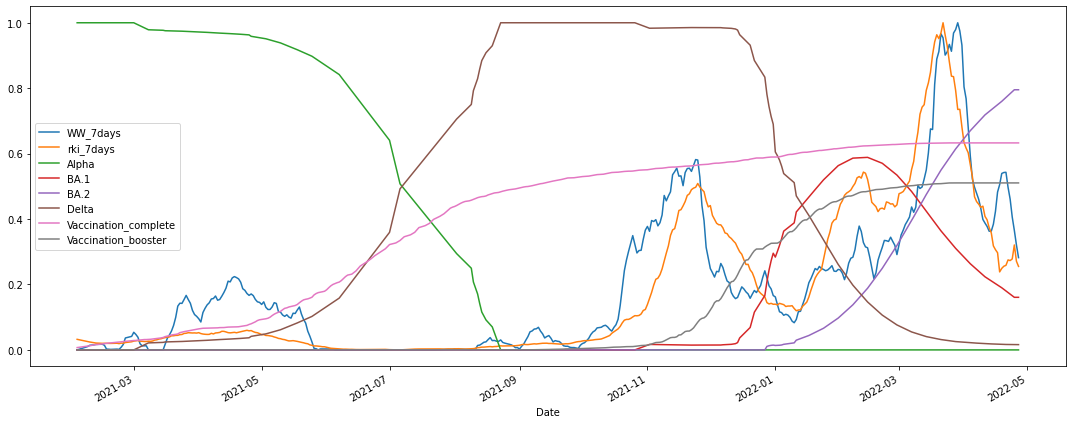

In [89]:
## Config
k = 7
exclude_days = 60
## Prepare windowed data
scaler = MinMaxScaler()
df_scaled = df.copy().filter(regex=f"^rki_{k}\w+|WW_{k}days")
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(("Alpha", "Delta", "BA.1", "BA.2", "Omicron"))).join(df.filter(regex="(Booster|Doppelt).*"))
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(regex="^Vaccination|Alpha|Delta|BA.1|BA.2"))
X = np.array([win.values.transpose() for win in df_scaled.filter(regex=f"^(?!rki_{k}days)").rolling(30) if len(win) == 30][:-1])
y = np.array([win.values[-1] for win in df_scaled.filter((f"rki_{k}days",)).rolling(31) if len(win) == 31])
X_train, X_test, y_train, y_test = train_test_split(X[:-exclude_days,:,:], y[:-exclude_days,:], random_state=1) # exclude last 'exclude_days' days
df_scaled.plot()
plt.tight_layout()
plt.savefig(f"machine_learning_input_{k}days.png")
plt.show()
# px.line(df_scaled)


In [90]:
## LSTM
def simple_model(X_train, dropout=0.05, recurrent_dropout=0.1):
    model = Sequential(name="simple")
    model.add(layers.LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=recurrent_dropout))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    # model.compile(loss="mse", optimizer=optimizers.adam_v2.Adam(learning_rate=.005))
    model.compile(loss="mse", optimizer="Adam")
    model.summary()
    return model

def deep_model(X_train, dropout=0.05, recurrent_dropout=0.1):
    model = Sequential(name="deep")
    model.add(layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.LSTM(32, bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=recurrent_dropout))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    # model.compile(loss="mse", optimizer=optimizers.adam_v2.Adam(learning_rate=.005))
    model.compile(loss="mse", optimizer="Adam")
    model.summary()
    return model

def deeper_model(X_train, dropout=0.05, recurrent_dropout=0.1):
    model = Sequential(name="deeper")
    model.add(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(64, bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=recurrent_dropout))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    # model.compile(loss="mse", optimizer=optimizers.adam_v2.Adam(learning_rate=.005))
    model.compile(loss="mse", optimizer="Adam")
    model.summary()
    return model


Model: "simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 16)                3008      
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


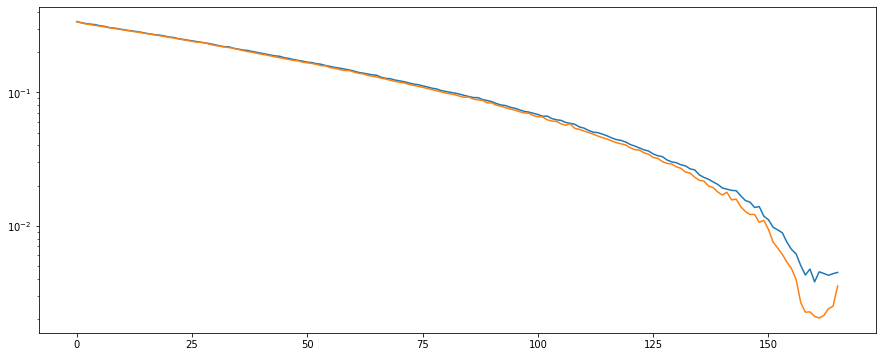

Model: "deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 7, 32)             8064      
                                                                 
 lstm_62 (LSTM)              (None, 7, 32)             8320      
                                                                 
 lstm_63 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 24,737
Trainable params: 24,737
Non-trainable params: 0
_________________________________________________________________


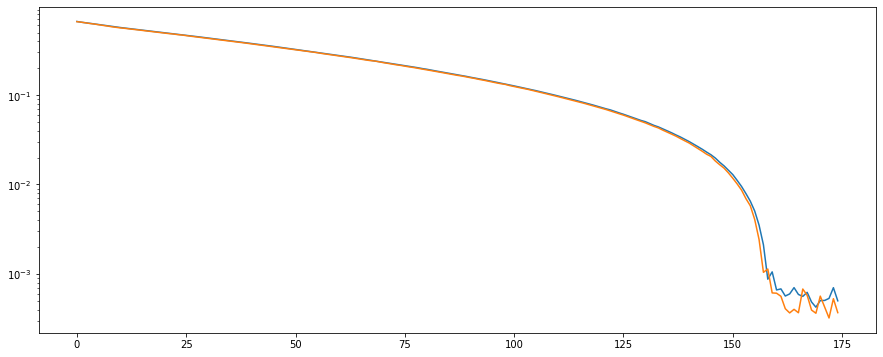

Model: "deeper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 7, 64)             24320     
                                                                 
 lstm_65 (LSTM)              (None, 7, 128)            98816     
                                                                 
 dropout_31 (Dropout)        (None, 7, 128)            0         
                                                                 
 lstm_66 (LSTM)              (None, 7, 128)            131584    
                                                                 
 dropout_32 (Dropout)        (None, 7, 128)            0         
                                                                 
 lstm_67 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_33 (Dropout)        (None, 64)                0    

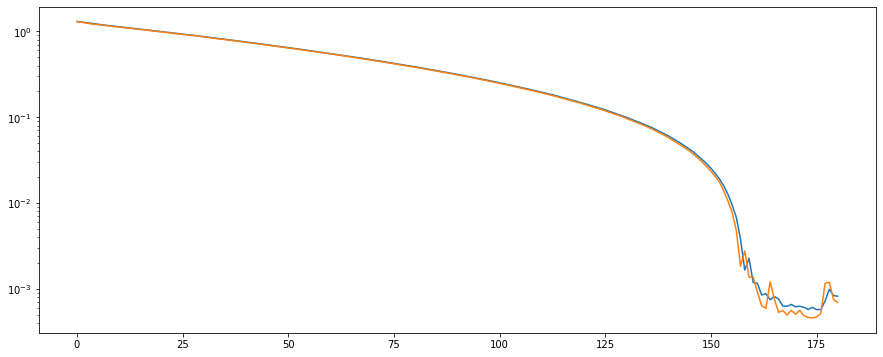

In [91]:
# fit network
def fit(model):
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(
        X_train,
        y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0,
        shuffle=True,
        callbacks=[callback]
    )
    plt.semilogy(pd.DataFrame(history.history))
    plt.show()
    return model
    
model = {}
for i, func in enumerate((simple_model, deep_model, deeper_model)):
    model[i] = func(X_train, dropout=0.1, recurrent_dropout=0.2)
    model[i] = fit(model[i])


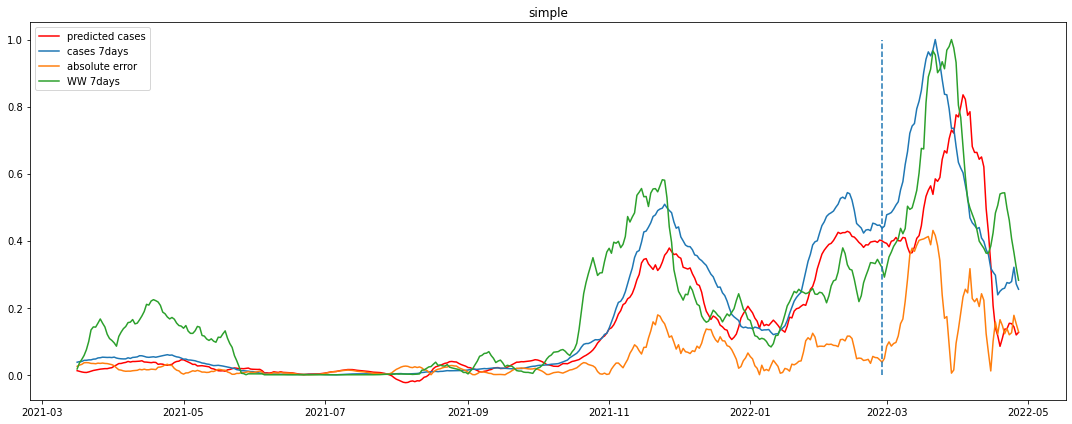

total error: 0.011
training error: 0.0096
test error: 0.03


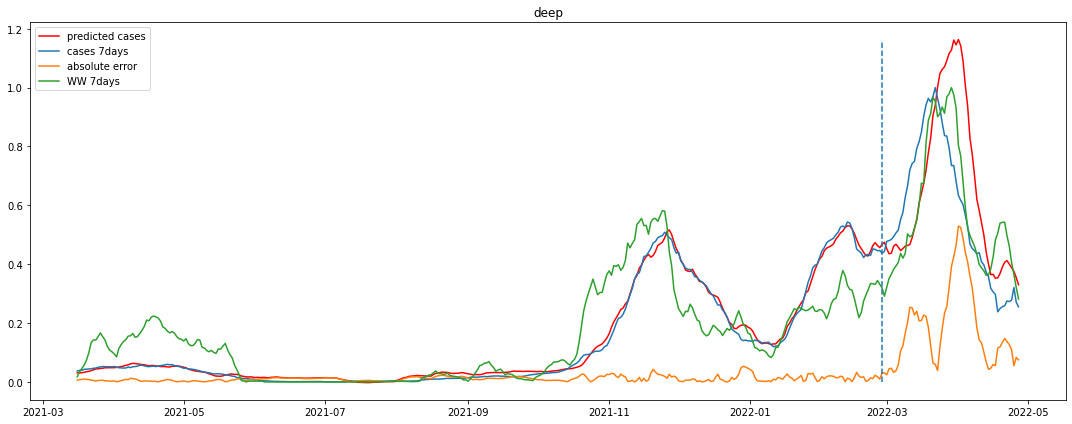

total error: 0.0083
training error: 0.0026
test error: 0.074


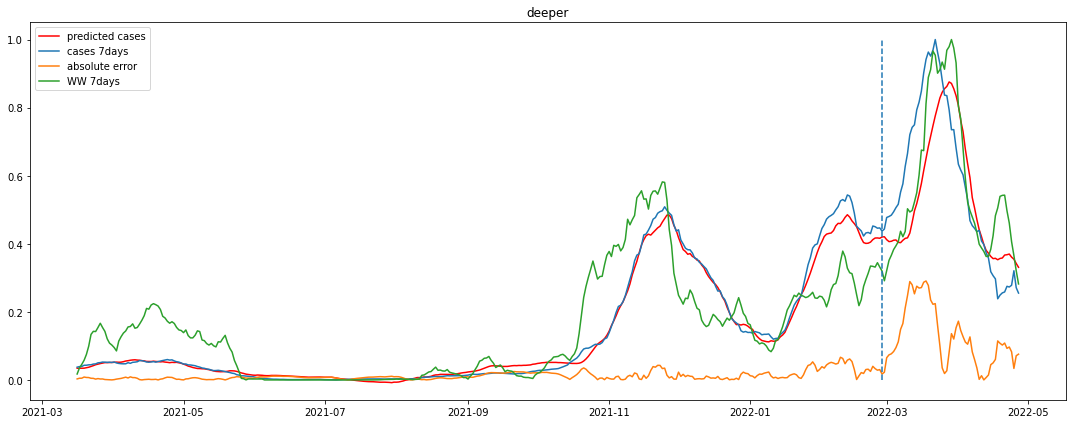

total error: 0.0038
training error: 0.0034
test error: 0.0089


In [92]:

for i in model:
    pred = model[i].predict(X)
    df_pred = df_scaled.copy()
    df_pred["pred"] = np.pad(np.squeeze(pred), [X.shape[-1], 0], constant_values=np.nan)
    df_pred[df_pred < 0] = 0
    df_pred["error"] = df_pred["pred"] - df_pred[f"rki_{k}days"]
    # df_pred.plot(figsize=(15,6), style={"pred": ".", "error": "-."})
    # px.line(df_pred)
    plt.figure(figsize=(15,6))
    plt.plot(df_pred.index[30:], pred, "r")
    plt.plot(df_pred.index[30:], y)
    plt.plot(df_pred.index[30:], np.abs(pred-y))
    plt.plot(df_pred.filter((f"WW_{k}days",)).iloc[30:])
    plt.title(model[i].name)
    plt.legend(("predicted cases", f"cases {k}days", "absolute error", f"WW {k}days"))
    plt.vlines(df_pred.index[-exclude_days], 0, max(1, pred.max()), linestyles="dashed")
    plt.tight_layout()
    plt.savefig(f"machine_learning_result_{k}days_{model[i].name}.png")
    plt.show()
    print(f"total error: {np.mean((pred-y)**2):.2g}")
    print(f"training error: {np.mean((pred-y)[:-30]**2):.2g}")
    print(f"test error: {np.mean((pred-y)[-30:]**2):.2g}")
    # model.evaluate(X_test, y_test)